In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders
import zipfile
import signal

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from google.colab import files
from keras.preprocessing import image

%matplotlib inline

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-04-14 10:43:39--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  1.85MB/s    in 3m 59s  

2021-04-14 10:47:39 (1.29 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
os.listdir('/tmp/rockpaperscissors/rps-cv-images')

['paper', 'scissors', 'README_rpc-cv-images.txt', 'rock']

In [ ]:
splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', 
                    output="/tmp/rps", ratio=(.6, .4), seed=123)

Copying files: 2188 files [00:01, 1563.19 files/s]


In [ ]:
print(f"Train rock: {len(os.listdir('/tmp/rps/train/rock'))}") 
print(f"Train paper: {len(os.listdir('/tmp/rps/train/paper'))}")
print(f"Train scissors: {len(os.listdir('/tmp/rps/train/scissors'))}")

print(f"Validation rock: {len(os.listdir('/tmp/rps/val/rock'))}") 
print(f"Validation paper: {len(os.listdir('/tmp/rps/val/paper'))}")
print(f"Validation scissors: {len(os.listdir('/tmp/rps/val/scissors'))}")

Train rock: 435
Train paper: 427
Train scissors: 450
Validation rock: 291
Validation paper: 285
Validation scissors: 300


In [ ]:
data_dir = '/tmp/rps'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

rock_images = os.listdir(os.path.join(train_dir, 'rock'))
paper_images = os.listdir(os.path.join(train_dir, 'paper'))
scissors_images = os.listdir(os.path.join(train_dir, 'scissors'))

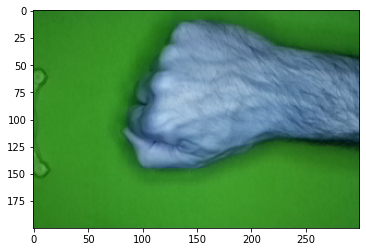

In [ ]:
for img in rock_images:
  img_array = cv2.imread(os.path.join(os.path.join(train_dir, 'rock'),img))
  plt.imshow(img_array)
  break

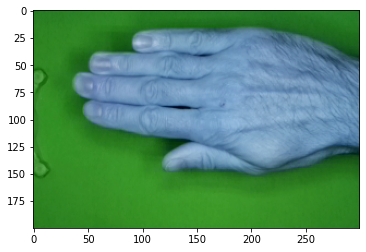

In [ ]:
for img in paper_images:
  img_array = cv2.imread(os.path.join(os.path.join(train_dir, 'paper'),img))
  plt.imshow(img_array)
  break

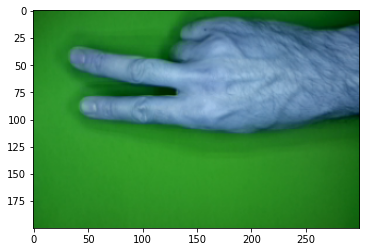

In [ ]:
for img in scissors_images:
  img_array = cv2.imread(os.path.join(os.path.join(train_dir, 'scissors'),img))
  plt.imshow(img_array)
  break

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1312 images belonging to 3 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 876 images belonging to 3 classes.


In [ ]:
validation_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.961):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  
      epochs=30,
      verbose=2,
      validation_data = validation_generator,
      validation_steps=7,
      callbacks=[callbacks])

Epoch 1/30
25/25 - 24s - loss: 1.0270 - accuracy: 0.4338 - val_loss: 0.7392 - val_accuracy: 0.6562
Epoch 2/30
25/25 - 23s - loss: 0.5641 - accuracy: 0.7800 - val_loss: 0.4884 - val_accuracy: 0.7812
Epoch 3/30
25/25 - 22s - loss: 0.3716 - accuracy: 0.8662 - val_loss: 0.2661 - val_accuracy: 0.9062
Epoch 4/30
25/25 - 23s - loss: 0.2858 - accuracy: 0.8888 - val_loss: 0.2534 - val_accuracy: 0.9062
Epoch 5/30
25/25 - 22s - loss: 0.2470 - accuracy: 0.9125 - val_loss: 0.4019 - val_accuracy: 0.8571
Epoch 6/30
25/25 - 23s - loss: 0.2135 - accuracy: 0.9212 - val_loss: 0.2680 - val_accuracy: 0.8929
Epoch 7/30
25/25 - 23s - loss: 0.2303 - accuracy: 0.9187 - val_loss: 0.1473 - val_accuracy: 0.9598
Epoch 8/30
25/25 - 23s - loss: 0.1273 - accuracy: 0.9538 - val_loss: 0.1764 - val_accuracy: 0.9330
Epoch 9/30
25/25 - 23s - loss: 0.1763 - accuracy: 0.9463 - val_loss: 0.2057 - val_accuracy: 0.9241
Epoch 10/30
25/25 - 23s - loss: 0.1657 - accuracy: 0.9362 - val_loss: 0.1107 - val_accuracy: 0.9509
Epoch 11/

In [ ]:
loss_train,acc_train = model.evaluate(train_generator)
loss_val,acc_val = model.evaluate(validation_generator)

report = pd.DataFrame({'Score':['Train','Validasi'],
                       'Loss':[loss_train,loss_val],
                       'Accuracy':[acc_train,acc_val]})
report

28/28 [==============================] - 11s 384ms/step - loss: 0.1687 - accuracy: 0.9509


,Score,Loss,Accuracy
0,Train,0.075613,0.974848
1,Validasi,0.168664,0.950913


Saving 2DQbLQfHlfrcATqi.png to 2DQbLQfHlfrcATqi.png
2DQbLQfHlfrcATqi.png is a paper


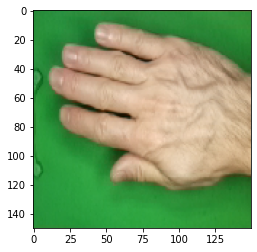

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=16)
  
  if classes[0,0] == 1:
    print(fn + " is a paper")
  elif classes[0,1] == 1:
    print(fn + " is a rock")
  else:
    print(fn + " is a scissors")

In [ ]:
os.kill(os.getpid(), signal.SIGKILL)